Данное задание основано на материалах лекций по композициям алгоритмов.

Вы научитесь: 
+ работать с градиентным бустингом и подбирать его гиперпараметры

+ сравнивать разные способы построения композиций

+ понимать, в каком случае лучше использовать случайный лес, а в каком — градиентный бустинг

+ использовать метрику log-loss

**Введение**
Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.

На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.

Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать log-loss:
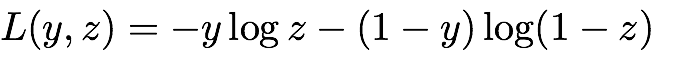
Здесь через y обозначен истинный ответ, через z — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.

Реализация в sklearn
В пакете scikit-learn градиентный бустинг реализован в модуле ensemble в виде классов GradientBoostingClassifier и GradientBoostingRegressor. Основные параметры, которые будут интересовать нас: n_estimators, learning_rate. Иногда может быть полезен параметр verbose для отслеживания процесса обучения.

Чтобы была возможность оценить качество построенной композиции на каждой итерации, у класса есть метод staged_decision_function. Для заданной выборки он возвращает ответ на каждой итерации.

Помимо алгоритмов машинного обучения, в пакете scikit-learn представлено большое число различных инструментов. В этом задании будет предложено воспользоваться функцией train_test_split модуля cross_validation. С помощью нее можно разбивать выборки случайным образом. На вход можно передать несколько выборок (с условием, что они имеют одинаковое количество строк). Пусть, например, имеются данные X и y, где X — это признаковое описание объектов, y — целевое значение. Тогда следующий код будет удобен для разбиения этих данных на обучающее и тестовое множества:

In [ ]:
X_train, X_test, y_train, y_test = 
                     train_test_split(X, y, 
                                      test_size=0.33, 
                                      random_state=42)

Обратите внимание, что при фиксированном параметре random_state результат разбиения можно воспроизвести.

Метрика log-loss реализована в пакете metrics: sklearn.metrics.log_loss. Заметим, что данная метрика предназначена для классификаторов, выдающих оценку принадлежности классу, а не бинарные ответы. И градиентный бустинг, и случайный лес умеют строить такие прогнозы — для этого нужно использовать метод predict_proba:

In [ ]:
pred = clf.predict_proba(X_test)

Метод predict_proba возвращает матрицу, i-й столбец которой содержит оценки принадлежности i-му классу. 

Для рисования кривых качества на обучении и контроле можно воспользоваться следующим кодом:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(test_loss, 'r', linewidth=2)
plt.plot(train_loss, 'g', linewidth=2)
plt.legend(['test', 'train'])

https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf

**1. Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241.**

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from typing import List, Tuple
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv('./gbm-data.csv')

In [11]:
y = data['Activity'].values
X = data.iloc[:,1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

**2.Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:**



+ Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 1 / (1 + e^{−y_pred}), где y_pred — предсказанное значение.

In [23]:
def sigmoid(y_pred: np.array) -> np.array:
    return 1.0 / (1.0 + np.exp(-y_pred))

+ Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.

In [22]:
def log_loss_results(model, X: np.array, y: np.array) -> List[float]:
    return [log_loss(y, sigmoid(y_pred)) for y_pred in model.staged_decision_function(X)]


+ Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

In [32]:
def print_los(test_loss,train_loss):
    plt.figure()
    plt.plot(test_loss, 'r', linewidth=2)
    plt.plot(train_loss, 'g', linewidth=2)
    plt.xlabel('iter')
    plt.ylabel('Loss')
    plt.legend(['test', 'train'])
    plt.show()

Learning rate: 1
      Iter       Train Loss   Remaining Time 
         1           1.0190            7.70s
         2           0.9192            7.42s
         3           0.8272            7.39s
         4           0.7834            7.30s
         5           0.7109            7.23s
         6           0.6368            7.14s
         7           0.5797            7.13s
         8           0.5610            7.09s
         9           0.5185            7.02s
        10           0.4984            6.97s
        20           0.1999            6.62s
        30           0.1313            6.33s
        40           0.0790            6.07s
        50           0.0511            5.85s
        60           0.0352            5.58s
        70           0.0245            5.30s
        80           0.0162            5.02s
        90           0.0114            4.72s
       100           0.0077            4.43s
       200           0.0002            1.45s


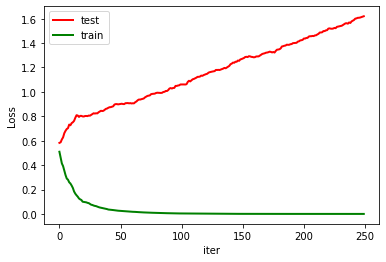

Learning rate: 0.5
      Iter       Train Loss   Remaining Time 
         1           1.1255            7.95s
         2           1.0035            7.54s
         3           0.9386            7.39s
         4           0.8844            7.30s
         5           0.8381            7.28s
         6           0.7995            7.18s
         7           0.7559            7.13s
         8           0.7205            7.12s
         9           0.6958            7.08s
        10           0.6725            7.01s
        20           0.4672            6.85s
        30           0.3179            6.51s
        40           0.2274            6.20s
        50           0.1774            5.85s
        60           0.1394            5.55s
        70           0.1050            5.23s
        80           0.0805            4.92s
        90           0.0650            4.62s
       100           0.0511            4.34s
       200           0.0058            1.46s


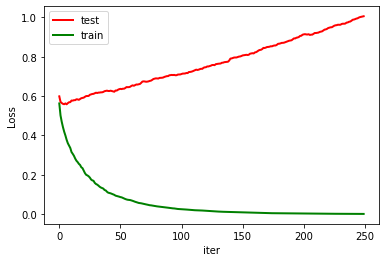

Learning rate: 0.3
      Iter       Train Loss   Remaining Time 
         1           1.2095            7.20s
         2           1.1006            7.05s
         3           1.0240            6.98s
         4           0.9729            6.93s
         5           0.9387            6.89s
         6           0.8948            6.85s
         7           0.8621            6.82s
         8           0.8360            6.82s
         9           0.8171            6.84s
        10           0.7883            6.82s
        20           0.6029            6.57s
        30           0.4760            6.26s
        40           0.3879            6.03s
        50           0.3325            5.76s
        60           0.2759            5.50s
        70           0.2304            5.31s
        80           0.1969            5.00s
        90           0.1718            4.69s
       100           0.1404            4.38s
       200           0.0358            1.44s


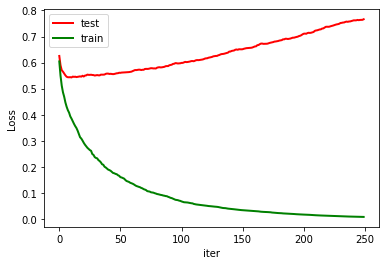

Learning rate: 0.2
      Iter       Train Loss   Remaining Time 
         1           1.2613            6.95s
         2           1.1715            6.93s
         3           1.1009            6.90s
         4           1.0529            6.93s
         5           1.0130            6.89s
         6           0.9740            6.85s
         7           0.9475            6.82s
         8           0.9197            6.79s
         9           0.8979            6.76s
        10           0.8730            6.73s
        20           0.7207            6.45s
        30           0.6055            6.22s
        40           0.5244            5.94s
        50           0.4501            5.65s
        60           0.3908            5.38s
        70           0.3372            5.14s
        80           0.3009            4.84s
        90           0.2603            4.55s
       100           0.2327            4.26s
       200           0.0835            1.42s


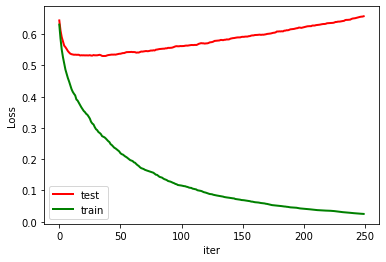

Learning rate: 0.1
      Iter       Train Loss   Remaining Time 
         1           1.3199            6.95s
         2           1.2645            7.05s
         3           1.2170            7.06s
         4           1.1775            6.99s
         5           1.1404            6.94s
         6           1.1106            6.94s
         7           1.0844            6.89s
         8           1.0617            6.88s
         9           1.0411            6.84s
        10           1.0223            6.80s
        20           0.8864            6.50s
        30           0.7844            6.22s
        40           0.7176            5.95s
        50           0.6590            5.66s
        60           0.6120            5.38s
        70           0.5599            5.13s
        80           0.5242            4.87s
        90           0.4829            4.62s
       100           0.4473            4.37s
       200           0.2379            1.48s


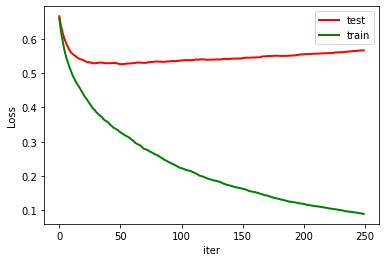

In [33]:
min_log_loss
for rate in [1, 0.5, 0.3, 0.2, 0.1]:
    print(f"Learning rate: {rate}")
    
    gradboost = GradientBoostingClassifier(n_estimators=250, verbose=True, random_state=241, learning_rate=rate)
    gradboost.fit(X_train,y_train)
    
    train_loss = log_loss_results(gradboost, X_train, y_train)
    test_loss = log_loss_results(gradboost, X_test, y_test)
    print_los(test_loss, train_loss)

**3. Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? В ответе укажите одно из слов overfitting либо underfitting.**

In [75]:
with open('./1.txt', 'w') as f:
    f.write("overfitting")
f.close()

**4. Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.**

In [66]:
gradboost = GradientBoostingClassifier(n_estimators=250, verbose=True, random_state=241, learning_rate=0.2)
gradboost.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613            7.95s
         2           1.1715            7.67s
         3           1.1009            7.55s
         4           1.0529            7.48s
         5           1.0130            7.38s
         6           0.9740            7.30s
         7           0.9475            7.31s
         8           0.9197            7.24s
         9           0.8979            7.16s
        10           0.8730            7.11s
        20           0.7207            6.86s
        30           0.6055            6.50s
        40           0.5244            6.24s
        50           0.4501            5.93s
        60           0.3908            5.61s
        70           0.3372            5.33s
        80           0.3009            5.04s
        90           0.2603            4.74s
       100           0.2327            4.44s
       200           0.0835            1.47s


GradientBoostingClassifier(learning_rate=0.2, n_estimators=250,
                           random_state=241, verbose=True)

In [64]:
y_pred = gradboost.predict_proba(X_test)[:,1]
log_loss(y_true=y_test, y_pred=y_pred)

0.6574280694152926

In [67]:
test_loss = log_loss_results(gradboost, X=X_test, y=y_test)
test_loss = pd.Series(test_loss)
test_loss[test_loss == test_loss.min()]

36    0.530165
dtype: float64

In [74]:
test_loss.iloc[-1:]

249    0.657428
dtype: float64

In [76]:
with open('./2.txt', 'w') as f:
    f.write("0.53 37")
f.close()

**6. 5. На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)**

In [57]:
gradboost = RandomForestClassifier(n_estimators=37, random_state=241)
gradboost.fit(X_train, y_train)

y_pred = gradboost.predict_proba(X_test)[:, 1]
test_loss = log_loss(y_test, y_pred)
test_loss

0.5410941951182815

In [60]:
with open('./3.txt', 'w') as f:
    f.write("0.54")
f.close()